In [1]:
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.optim as optim
import requests
from torchvision import transforms, models

vgg19 is subdivided into features (the convolutional and pooling layers) and classifier (the three linear, classifier layers at the end). We want to load the features portion and freeze the weights

In [2]:
# get vgg19 features
vgg = models.vgg19(pretrained=True).features

# freeze vgg params, only optimizing target image
for param in vgg.parameters():
    param.requires_grad_(False)

In [3]:
# move to GPU if possible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace)
  (18): MaxPool2d(kernel_size=2, stride=2, padding=0, 

jpg or png images

In [4]:
def load_image(img_path, max_size=400, shape=None):
    '''load in and transform image that is <= 400px in x-y dims'''
    if "http" in img_path:
        response = requests.get(img_path)
        image = Image.open(BytesIO(response.content)).convert('RGB')
    else:
        image = Image.open(img_path).convert('RGB')
        
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
        
    if shape is not None:
        size = shape
        
    in_transform = transforms.Compose([
                    transforms.Resize(size),
                    transforms.ToTensor(),
                    transforms.Normalize((0.485, 0.456, 0.406),
                                        (0.229, 0.224, 0.225))])
    
    # discard the transparent alpha channel (that's the :3) and add the batch dimension
    # what does this mean ^ ^ ^
    image = in_transform(image)[:3,:,:].unsqueeze(0)
    
    return image

Now, load in images by file name and force the style image to be the same size as content image

In [5]:
import os
os.listdir()

['.ipynb_checkpoints',
 'blue_ridge_falls.jpg',
 'bross-blueridgefalls.ipynb',
 'bross.ipynb',
 'bross_rainier.png',
 'bross_rainier_blueridgefalls.png',
 'bross_rainier_blueridgefalls2.png',
 'gray_mountain.jpg',
 'on_a_clear_day.jpg',
 'rainier_lake.jpg',
 'Style_Transfer_Solution.ipynb']

In [6]:
# load content to pull style from
content = load_image('rainier_lake.jpg')

# load image to transfer style to, and resize to style image
style = load_image('blue_ridge_falls.jpg', shape=content.shape[-2:]).to(device)

In [7]:
# helper function to un-normalize img
# and to convert from Tensor to NumPy img for display
def img_converter(tensor):
    # display tensor as image
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.496))
    image = image.clip(0,1)
    
    return image

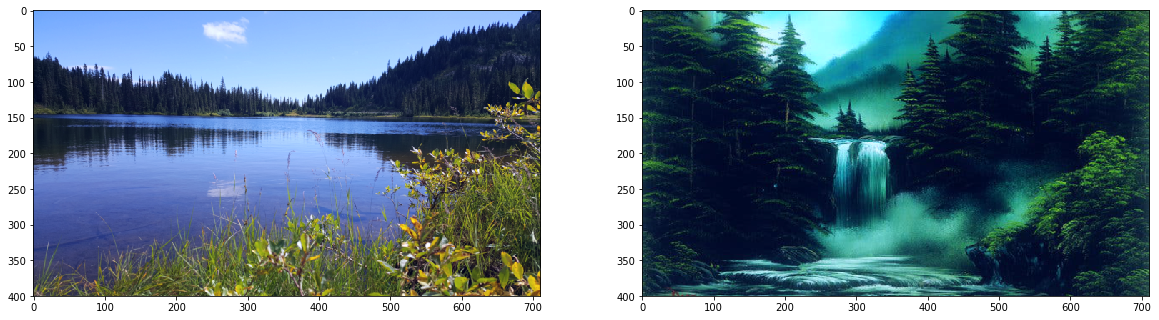

In [8]:
# display the images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
# content and style ims side-by-side
ax1.imshow(img_converter(content))
ax2.imshow(img_converter(style))

plt.show()

Obtaining the style features

In [9]:
def get_features(image, model, layers=None):
    # run through an img to get style features for a set of layers
    if layers is None:
        layers = {'0': 'conv1_1',
                  '5': 'conv2_1', 
                  '10': 'conv3_1', 
                  '19': 'conv4_1',
                  '21': 'conv4_2',  ## content representation
                  '28': 'conv5_1'}
        
        
    features = {}
    x = image
    # model._modules is a dictionary holding each module in the model
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
            
    return features

In [10]:
def gram_matrix(tensor):
    """ Calculate the Gram Matrix of a given tensor 
        Gram Matrix: https://en.wikipedia.org/wiki/Gramian_matrix
    """
    
    # get the batch_size, depth, height, and width of the Tensor
    _, d, h, w = tensor.size()
    
    # reshape so we're multiplying the features for each channel
    tensor = tensor.view(d, h * w)
    
    # calculate the gram matrix
    gram = torch.mm(tensor, tensor.t())
    
    return gram

Extract features and calculate the Gram matrix for each layer

In [11]:
content = content.to('cuda')
style = style.to('cuda')

In [12]:
# get content and style features only once before training
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

# calculate the gram matrices for each layer of our style representation
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

# create a third "target" image and prep it for change
# it is a good idea to start off with the target as a copy of our *content* image
# then iteratively change its style
target = content.clone().requires_grad_(True).to(device)

Loss and weights

In [26]:
# weights for each style layer 
# weighting earlier layers more will result in *larger* style artifacts
# notice we are excluding `conv4_2` our content representation
style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.75,
                 'conv3_1': 0.5,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}

content_weight = 1  # alpha
style_weight = 1e6  # beta # 1e6 original

Total loss:  88880.2109375


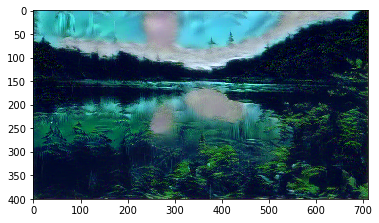

Total loss:  76456.5390625


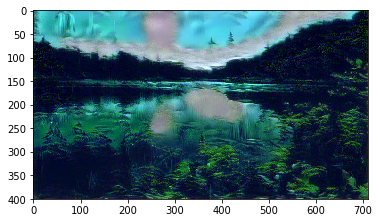

Total loss:  65082.89453125


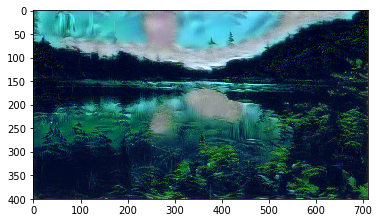

Total loss:  56734.90234375


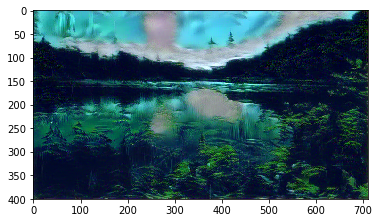

Total loss:  50351.4609375


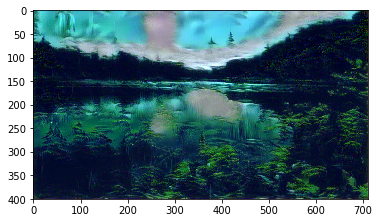

In [27]:
# for displaying the target image, intermittently
show_every = 400

# iteration hyperparameters
optimizer = optim.Adam([target], lr=0.003)
steps = 2000  # decide how many iterations to update your image (5000)

for ii in range(1, steps+1):
    
    # get the features from your target image
    target_features = get_features(target, vgg)
    
    # the content loss
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
    
    # the style loss
    # initialize the style loss to 0
    style_loss = 0
    # then add to it for each layer's gram matrix loss
    for layer in style_weights:
        # get the "target" style representation for the layer
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        _, d, h, w = target_feature.shape
        # get the "style" style representation
        style_gram = style_grams[layer]
        # the style loss for one layer, weighted appropriately
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        # add to the style loss
        style_loss += layer_style_loss / (d * h * w)
        
    # calculate the *total* loss
    total_loss = content_weight * content_loss + style_weight * style_loss
    
    # update your target image
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    # display intermediate images and print the loss
    if  ii % show_every == 0:
        print('Total loss: ', total_loss.item())
        plt.imshow(img_converter(target))
        plt.show()

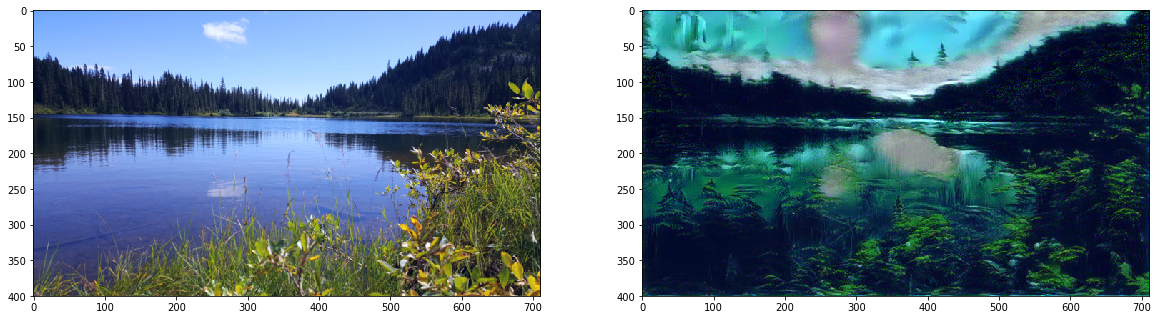

In [28]:
# display content and final, target image
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(img_converter(content))
ax2.imshow(img_converter(target))

In [21]:
stylized_img = img_converter(target)

In [22]:
plt.imsave('bross_rainier_blueridgefalls5.png', stylized_img)